In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.0.0


In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
def build_model(input_size):
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[input_size]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', 'acc'])

  return model

""" displays prediction diagram by applying model of source room to 
data of target room
"""
def prediction_graph(source_room, target_room):
    
    test_predictions = rooms[source_room]['model'].predict(rooms[target_room]['normed_test_data']).flatten()

    a = plt.axes(aspect='equal')
    plt.scatter(rooms[target_room]['test_labels'], test_predictions)
    plt.xlabel('True Values [Occupants]')
    plt.ylabel('Predictions [Occupants]')
    lims = [0, 80]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)

In [4]:
""" Merge time columns based on given interval
"""
def merge_time(input_df, data_column, interval = 30, time_filter = True):
    input_df['merged_time'] = input_df.apply(lambda row: str(row['year']) +
                         str(row['month']).zfill(2) + 
                         str(row['day']).zfill(2) +
                         row['time'][:2] + 
                         str(int(row['time'][3:5]) // interval).zfill(2), axis=1)
    
    if time_filter:
        drop_index = input_df[input_df['time'].map(lambda row: int(row[:2]) < 6 or int(row[:2]) > 14)].index
        input_df.drop(drop_index , inplace=True)
    
    
    return input_df.groupby(['merged_time'])[data_column].mean()
    

""" normalize data
"""
def norm(x, x_stats):
  return (x - x_stats['mean']) / x_stats['std']
    

In [5]:
def build_dataset(room):

    ### filled
    occupancy_file = "/Users/amin/Downloads/Dataset/filleddata/occupant_count_room_%d.csv"%room
    co2_file = "/Users/amin/Downloads/Dataset/filleddata/co2_room_%d.csv"%room
    temperature_file = "/Users/amin/Downloads/Dataset/filleddata/temperature_room_%d.csv"%room
    #illuminance_file = "/Users/amin/Downloads/Dataset/filleddata/Illuminance_room_%d.csv"%room
    humidity_file = "/Users/amin/Downloads/Dataset/filleddata/humidity_room_%d.csv"%room

    ### original
    #occupancy_file = "/Users/amin/Downloads/Dataset/original/occupant_count_room_1.csv"
    #co2_file = "/Users/amin/Downloads/Dataset/original/co2_room_1.csv"

    occ_columns = ['year', 'month', 'time', 'day', 'workday', 'occupancy']
    co2_columns = ['year', 'month', 'time', 'day', 'workday', 'co2']
    #tmp_columns = ['year', 'month', 'time', 'day', 'workday', 'temperature']
    #ill_columns = ['year', 'month', 'time', 'day', 'workday', 'illuminance']
    #hum_columns = ['year', 'month', 'time', 'day', 'workday', 'humidity']

    occ_df = pd.read_csv(occupancy_file, names=occ_columns, skiprows=1)
    co2_df = pd.read_csv(co2_file, names=co2_columns, skiprows=1)
    #tmp_df = pd.read_csv(temperature_file, names=tmp_columns, skiprows=1)
    #ill_df = pd.read_csv(illuminance_file, names=ill_columns, skiprows=1)
    #hum_df = pd.read_csv(humidity_file, names=hum_columns, skiprows=1)
    
    
    occ_grouped = merge_time(occ_df, 'occupancy')
    co2_grouped = merge_time(co2_df, 'co2')
    #tmp_grouped = merge_time(tmp_df, 'temperature')
    #ill_grouped = merge_time(ill_df, 'illuminance')
    #hum_grouped = merge_time(hum_df, 'humidity')
    
    
    #dataset = pd.concat([occ_grouped, co2_grouped, tmp_grouped, ill_grouped, hum_grouped], axis=1, sort=False)
    dataset = pd.concat([occ_grouped, co2_grouped], axis=1, sort=False)
    dataset['occupancy'] = dataset['occupancy'].round()

    # simplifying occupancy in 10X groups 
    #dataset['occupancy'] = dataset['occupancy']//10


    # simplifying occupancy in 20X groups 
    #dataset['occupancy'] = dataset['occupancy']//20

    # simplifying occupancy in 5X groups 
    #dataset['occupancy'] = dataset['occupancy']//5 
    
    return dataset

In [6]:
room_dataset = {1: build_dataset(1), 2:build_dataset(2), 3:build_dataset(3)}

In [28]:
room_id = 1
dataset = room_dataset[room_id].copy()
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# dataset statistics
train_stats = train_dataset.describe()
train_stats.pop("occupancy")
train_stats = train_stats.transpose()
print(train_stats)

#split featured from lables
train_labels = train_dataset.pop('occupancy')
test_labels = test_dataset.pop('occupancy')

# normalize the data
normed_train_data = norm(train_dataset, train_stats)
normed_test_data = norm(test_dataset, train_stats)

     count        mean         std         min        25%         50%  \
co2  634.0  646.489927  133.201777  450.613337  521.43466  634.767994   

           75%         max  
co2  757.16534  992.810677  


In [41]:
test_labels
#example_batch = normed_train_data[:10]
#example_result = model.predict(example_batch)
#example_result

merged_time
201803231001    19.0
201803231101    15.0
201803390601     1.0
201803390801     3.0
201803391100    40.0
                ... 
201902210801    29.0
201902210901    30.0
201902211000    52.0
201902211300    65.0
201902300701     0.0
Name: occupancy, Length: 158, dtype: float64

In [46]:
model = build_model(len(train_dataset.keys()))
model.summary()

EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, acc:0.1183,  loss:821.5220,  mae:20.3842,  mse:821.5220,  val_acc:0.0315,  val_loss:830.8117,  val_mae:20.5124,  val_mse:830.8116,  
..................................................

In [49]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,acc,val_loss,val_mae,val_mse,val_acc,epoch
45,212.721093,10.399535,212.721069,0.100592,245.150344,11.325856,245.150345,0.031496,45
46,212.816102,10.436784,212.816101,0.100592,245.345249,11.390707,245.345261,0.031496,46
47,212.751222,10.430744,212.751236,0.100592,245.286081,11.385125,245.286072,0.031496,47
48,212.806983,10.397580,212.806976,0.100592,245.262839,11.341304,245.262848,0.031496,48
49,212.757583,10.454549,212.757599,0.100592,245.500172,11.347604,245.500183,0.031496,49


In [56]:
rooms = {}
for room_id in [1,2,3]:
    dataset = room_dataset[room_id].copy()
    train_dataset = dataset.sample(frac=0.8,random_state=0)
    test_dataset = dataset.drop(train_dataset.index)

    # dataset statistics
    train_stats = train_dataset.describe()
    train_stats.pop("occupancy")
    train_stats = train_stats.transpose()
    print(train_stats)

    #split featured from lables
    train_labels = train_dataset.pop('occupancy')
    test_labels = test_dataset.pop('occupancy')

    # normalize the data
    normed_train_data = norm(train_dataset, train_stats)
    normed_test_data = norm(test_dataset, train_stats)
    
    model = build_model(len(train_dataset.keys()))
    model.summary()

    EPOCHS = 1000

    # The patience parameter is the amount of epochs to check for improvement
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

    history = model.fit(normed_train_data, train_labels, 
                        epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                        callbacks=[early_stop, tfdocs.modeling.EpochDots()])
   
    #loss, mae, mse, acc = model.evaluate(normed_test_data, test_labels, verbose=2)
    rooms[room_id] = {'normed_test_data' : normed_test_data, 'test_labels' : test_labels, 'model' : model}

     count        mean         std         min        25%         50%  \
co2  634.0  646.489927  133.201777  450.613337  521.43466  634.767994   

           75%         max  
co2  757.16534  992.810677  
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, acc:0.1144,  loss:817.5282,  mae:20.3648,  mse:817.5282,  val_acc:0.0315,  val_loss:823.2487,  val_mae:20.4374,  val_mse:823.2487,  
.................................

In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
12,52.716313,5.328670,52.716316,48.845676,5.326034,48.845676,12
13,52.428493,5.327903,52.428493,48.395137,5.280217,48.395138,13
14,52.232805,5.289383,52.232807,47.746510,5.237521,47.746510,14
15,51.743935,5.224553,51.743931,48.798268,5.281510,48.798271,15
16,51.547192,5.260222,51.547188,48.557871,5.248265,48.557873,16


Text(0, 0.5, 'MAE [Occupants]')

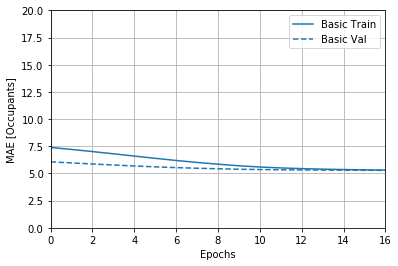

In [16]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 20])
plt.ylabel('MAE [Occupants]')

In [54]:
loss, mae, mse, acc = model.evaluate(normed_test_data, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} CO2".format(mae))

158/158 - 0s - loss: 157.2604 - mae: 9.2042 - mse: 157.2604 - acc: 0.0570
Testing set Mean Abs Error:  9.20 CO2


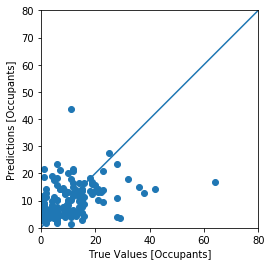

In [115]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Occupants]')
plt.ylabel('Predictions [Occupants]')
lims = [0, 80]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

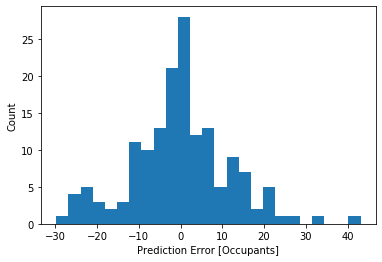

In [35]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Occupants]")
_ = plt.ylabel("Count")

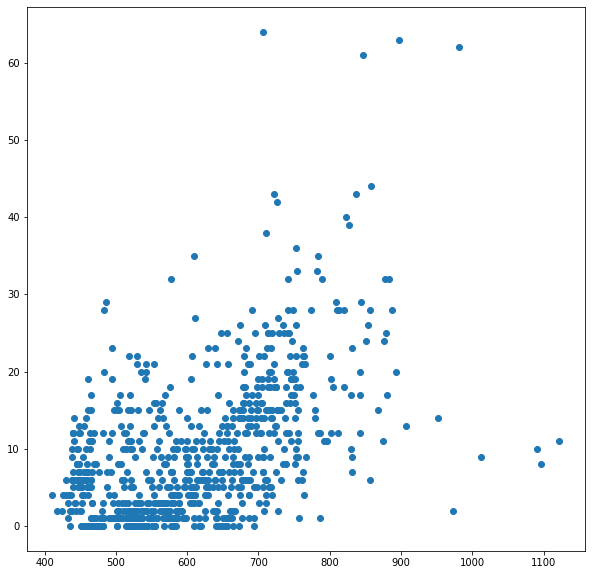

In [97]:
plt.figure(figsize=(10,10))
plt.scatter(dataset['co2'], dataset['occupancy'])

In [37]:
dataset.isna().sum()

occupancy      0
co2            0
temperature    0
humidity       0
dtype: int64

In [39]:
stats = room3_dataset.describe()
#stats.pop("occupancy")
stats = stats.transpose()
stats

,count,mean,std,min,25%,50%,75%,max
occupancy,792.0,9.267677,9.147288,0.000000,2.000000,7.000000,14.000000,64.000000
co2,792.0,606.989482,117.111679,410.784001,517.080005,591.909334,688.976001,1122.069375
temperature,792.0,21.719693,0.859987,19.600000,21.113334,21.433333,22.071667,24.283333
humidity,792.0,41.508731,10.575765,22.745098,33.725490,41.960784,47.941176,70.745098


In [433]:
stats = room1_dataset.describe()
#stats.pop("occupancy")
stats = stats.transpose()
stats

,count,mean,std,min,25%,50%,75%,max
occupancy,792.0,20.417929,19.877713,0.000000,2.000000,16.000000,35.000000,78.000000
co2,792.0,645.099691,130.880553,450.613337,521.704000,634.378665,750.965339,992.810677
temperature,792.0,23.218464,1.339944,20.000000,22.233334,23.038333,24.003333,27.593333
humidity,792.0,43.421701,10.893871,22.745098,35.147059,41.960785,50.980392,73.333334


In [434]:
stats = room2_dataset.describe()
#stats.pop("occupancy")
stats = stats.transpose()
stats

,count,mean,std,min,25%,50%,75%,max
occupancy,792.0,9.310606,7.836315,0.000000,3.000000,8.000000,14.000000,55.000000
co2,792.0,553.219758,95.962677,423.487999,475.493334,537.434665,612.309334,1133.973336
temperature,792.0,22.490008,1.013129,20.826666,21.793333,22.190001,22.935000,25.926666
humidity,792.0,41.789744,10.657568,22.745098,33.722222,41.960784,47.843137,70.666667


In [448]:
dataset = room3_dataset
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

#split featured from lables
train_labels = train_dataset.pop('occupancy')
test_labels = test_dataset.pop('occupancy')

# normalize the data
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

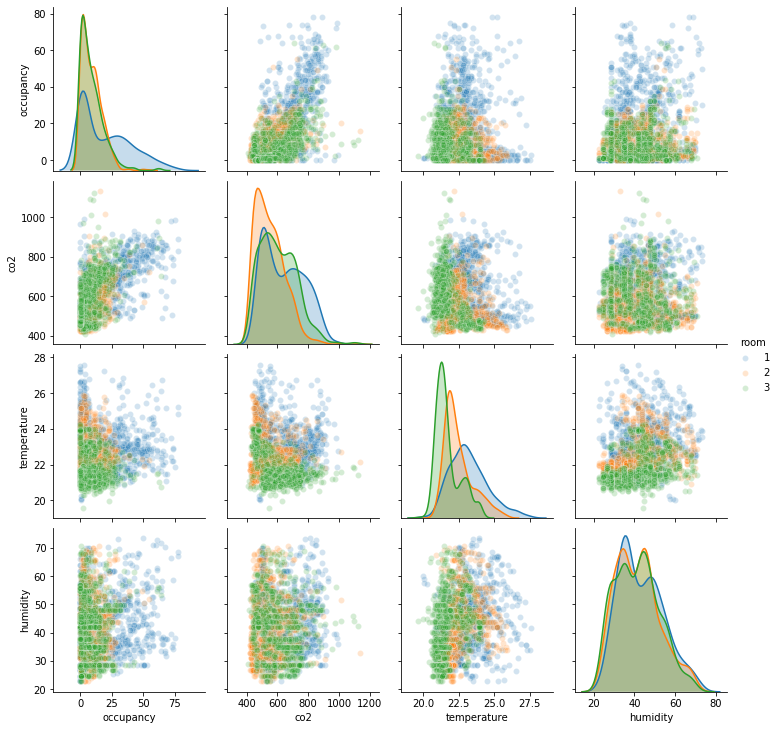

In [35]:
# Preparing dataset for overlay SNS diagram
room1_dataset['room'] = 1
room2_dataset['room'] = 2
room3_dataset['room'] = 3

dataset=room2_dataset.copy()
dataset = dataset.append(room1_dataset)

sns.pairplot(dataset, diag_kind="kde", hue="room",  plot_kws=dict(alpha=0.2))

<Figure size 432x288 with 0 Axes>

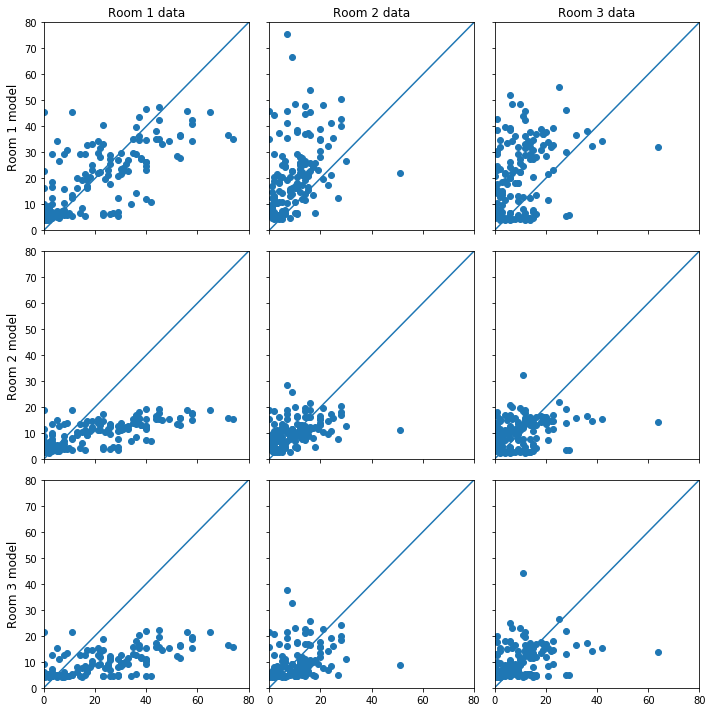

In [24]:
# Drawing prediction subplots
fig = plt.figure()
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10, 10))

lims = [0, 80]
plt.xlim(lims)
plt.ylim(lims)

cols = ['Room 1 data', 'Room 2 data', 'Room 3 data']
rows = ['Room 1 model', 'Room 2 model', 'Room 3 model']

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, size='large')

fig.tight_layout()


for source_room in [1,2,3]:
    for target_room in [1,2,3]:
        test_predictions = rooms[source_room]['model'].predict(rooms[target_room]['normed_test_data']).flatten()
        axs[source_room - 1 , target_room - 1].scatter(rooms[target_room]['test_labels'], test_predictions)
        _ = axs[source_room - 1 , target_room - 1].plot(lims, lims)
        #axs[source_room - 1, target_room -1].set_xlabel('True Values [Occupants]')
plt.show()

158/158 - 0s - loss: 156.9463 - mae: 9.2593 - mse: 156.9463 - acc: 0.0570
158/158 - 0s - loss: 296.8929 - mae: 12.7292 - mse: 296.8929 - acc: 0.0759
158/158 - 0s - loss: 350.1764 - mae: 14.6082 - mse: 350.1764 - acc: 0.1203
158/158 - 0s - loss: 320.5609 - mae: 12.8291 - mse: 320.5609 - acc: 0.0570
158/158 - 0s - loss: 49.8912 - mae: 4.8887 - mse: 49.8912 - acc: 0.0759
158/158 - 0s - loss: 82.6256 - mae: 6.6093 - mse: 82.6256 - acc: 0.1203
158/158 - 0s - loss: 331.0074 - mae: 13.4248 - mse: 331.0074 - acc: 0.0570
158/158 - 0s - loss: 63.1919 - mae: 5.4794 - mse: 63.1919 - acc: 0.0759
158/158 - 0s - loss: 84.2403 - mae: 6.2781 - mse: 84.2403 - acc: 0.1203


<Figure size 432x288 with 0 Axes>

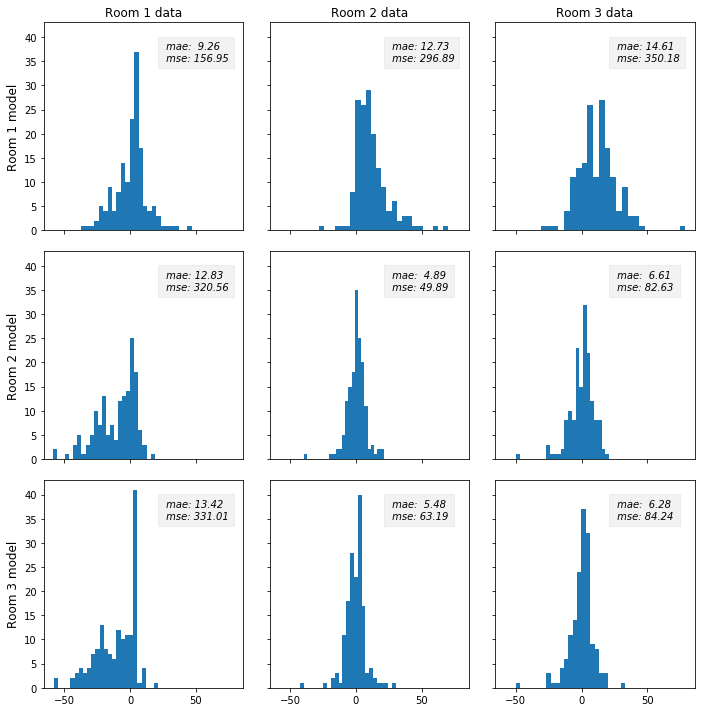

In [73]:
# Drawing error subplots
fig = plt.figure()
fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10, 10))

cols = ['Room 1 data', 'Room 2 data', 'Room 3 data']
rows = ['Room 1 model', 'Room 2 model', 'Room 3 model']

for ax, col in zip(axs[0], cols):
    ax.set_title(col)

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, size='large')

fig.tight_layout()

cnt = 1
for source_room in [1,2,3]:
    
    source_model = rooms[source_room]['model']

    for target_room in [1,2,3]:
        
        loss, mae, mse, acc = source_model.evaluate(rooms[target_room]['normed_test_data'], rooms[target_room]['test_labels'], verbose=2)
        axs[source_room - 1 , target_room - 1].text(25, 35, ' mae: {:5.2f} \n mse: {:5.2f}'.format(mae, mse), style='italic',
            bbox={'facecolor': 'black', 'alpha': 0.05, 'pad': 5})
        
        test_predictions = source_model.predict(rooms[target_room]['normed_test_data']).flatten()
        error = test_predictions - rooms[target_room]['test_labels'] 
        axs[source_room - 1 , target_room - 1].hist(error, bins = 25)
        
        #plt.xlabel("Prediction Error [Occupants]")
        #_ = plt.ylabel("Count")
        cnt += 1
    
        
plt.show()

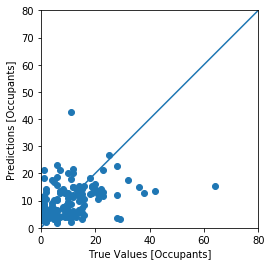

In [73]:
test_predictions = rooms[3]['model'].predict(rooms[3]['normed_test_data']).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Occupants]')
plt.ylabel('Predictions [Occupants]')
lims = [0, 80]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

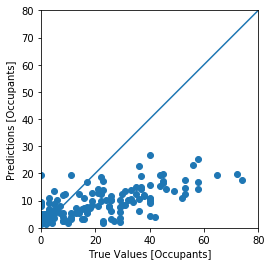

In [136]:
prediction_graph(3,1)

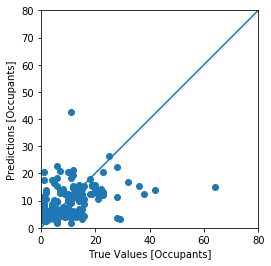

In [138]:
prediction_graph(3,3)

In [18]:
model.evaluate(normed_test_data, test_labels, verbose=2)

158/158 - 0s - loss: 82.7727 - mae: 6.3018 - mse: 82.7727


[82.77265765998936, 6.3018036, 82.77266]

In [23]:
model.metrics_names

['loss', 'mae', 'mse']

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                256       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________


In [15]:
dataset = room_dataset[3].copy()
dataset.pop('occupancy')
stats = dataset.describe().round(2)
stats.transpose()


,count,mean,std,min,25%,50%,75%,max
co2,792.0,606.99,117.11,410.78,517.08,591.91,688.98,1122.07
